# IMPORT PACKAGES

from google.colab import drive
drive.mount('/content/drive')

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from skimage import feature
from imutils import build_montages
from imutils import paths
import numpy as np
import argparse
import cv2
import os
from xgboost import XGBClassifier
import random
import matplotlib.pyplot as plt 
from matplotlib.figure import Figure

# LOADING DATASET

In [3]:
def load_split(path):
    # grab the list of images in the input directory, then initialize
    # the list of data (i.e., images) and class labels
    imagePaths = list(paths.list_images(path))
    data = []
    labels = []
    # loop over the image paths
    for imagePath in imagePaths:
        # extract the class label from the filename
        label = imagePath.split(os.path.sep)[-2]
        # load the input image, convert it to grayscale, and resize
        # it to 200x200 pixels, ignoring aspect ratio
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))
        # threshold the image such that the drawing appears as white
        # on a black background
        image = cv2.threshold(image, 0, 255,
                              cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        # quantify the image
        features = quantify_image(image)
        # update the data and labels lists, respectively
        data.append(features)
        labels.append(label)
    return (np.array(data), np.array(labels))


# Defining QUANTIFY IMAGES

In [4]:
def quantify_image(image):
    features = feature.hog(image, orientations=9,
                           pixels_per_cell=(10, 10), cells_per_block=(2, 2),
                           transform_sqrt=True, block_norm="L1")
    return features

In [5]:
def train_model(tpath):
    # initialize the models
    models = {
        "Rf": {
            "classifier": RandomForestClassifier(random_state=1),
            "accuracy": 0,
            "sensitivity": 0,
            "specificity": 0,
        },
        "Xgb": {
            "classifier": XGBClassifier(),
            "accuracy": 0,
            "sensitivity": 0,
            "specificity": 0,
        }
    }
    #trainingPath = os.path.sep.join(["/content/drive/MyDrive/Colab Notebooks/dataset", tpath,"training"])
    #testingPath = os.path.sep.join(["/content/drive/MyDrive/Colab Notebooks/dataset", tpath, "testing"])
    trainingPath = os.path.sep.join(["dataset", tpath,"training"])
    testingPath = os.path.sep.join(["dataset", tpath, "testing"])
    
   
    # load the data
    (trainX, trainY) = load_split(trainingPath)
    (testX, testY) = load_split(testingPath)
    # encode the labels
    le = LabelEncoder()
    trainY = le.fit_transform(trainY)
    testY = le.transform(testY)

    # train each model and calculate its metrics
    for model in models:
        models[model]["classifier"].fit(trainX, trainY)
        predictions = models[model]["classifier"].predict(testX)
        cm = confusion_matrix(testY, predictions).ravel()
        tn, fp, fn, tp = cm
        models[model]["accuracy"] = (tp + tn) / float(cm.sum())
        models[model]["sensitivity"] = tp / float(tp + fn)
        models[model]["specificity"] = tn / float(tn + fp)

    return models

In [6]:
spiralmodels=train_model("spiral")
wavemodels=train_model("wave")

In [7]:
print("Random Forrest vs XGBoost Classifier Spiral Models\n\n")
for metric in ("accuracy", "sensitivity", "specificity"):
    print(f"{metric.capitalize()}: ")
    print("Random Forrest={:.2f}%, XGBoost={:.2f}% \n".format(
        spiralmodels['Rf'][metric]*100, spiralmodels['Xgb'][metric]*100))
print("Random Forrest vs XGBoost Classifier Wave Models\n\n")
for metric in ("accuracy", "sensitivity", "specificity"):
    print(f"{metric.capitalize()}: ")
    print("Random Forrest={:.2f}%, XGBoost={:.2f}% \n".format(
        wavemodels['Rf'][metric]*100, wavemodels['Xgb'][metric]*100))


Random Forrest vs XGBoost Classifier Spiral Models


Accuracy: 
Random Forrest=86.67%, XGBoost=73.33% 

Sensitivity: 
Random Forrest=80.00%, XGBoost=73.33% 

Specificity: 
Random Forrest=93.33%, XGBoost=73.33% 

Random Forrest vs XGBoost Classifier Wave Models


Accuracy: 
Random Forrest=76.67%, XGBoost=73.33% 

Sensitivity: 
Random Forrest=73.33%, XGBoost=73.33% 

Specificity: 
Random Forrest=80.00%, XGBoost=73.33% 



In [8]:
def test_prediction(model, testingPath):
    # get the list of images
    testingPaths = list(paths.list_images(testingPath))
    output_images = []
    # pick 15 images at random
    for _ in range(15):
        image = cv2.imread(random.choice(testingPaths))
        output = image.copy()
        output = cv2.resize(output, (128, 128))
        # pre-process the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))
        image = cv2.threshold(image, 0, 255,
                              cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
      
        features = quantify_image(image)
        preds = model.predict([features])
        label = "Parkinsons" if preds[0] else "Healthy"

        color = (0, 255, 0) if label == "Healthy" else (0, 0, 255)
        cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    color, 2)
        output_images.append(output)
    plt.figure(figsize=(20, 20))
    for i in range(len(output_images)):
        plt.subplot(5, 5, i+1)
        plt.imshow(output_images[i])
        plt.axis("off")
    plt.show()

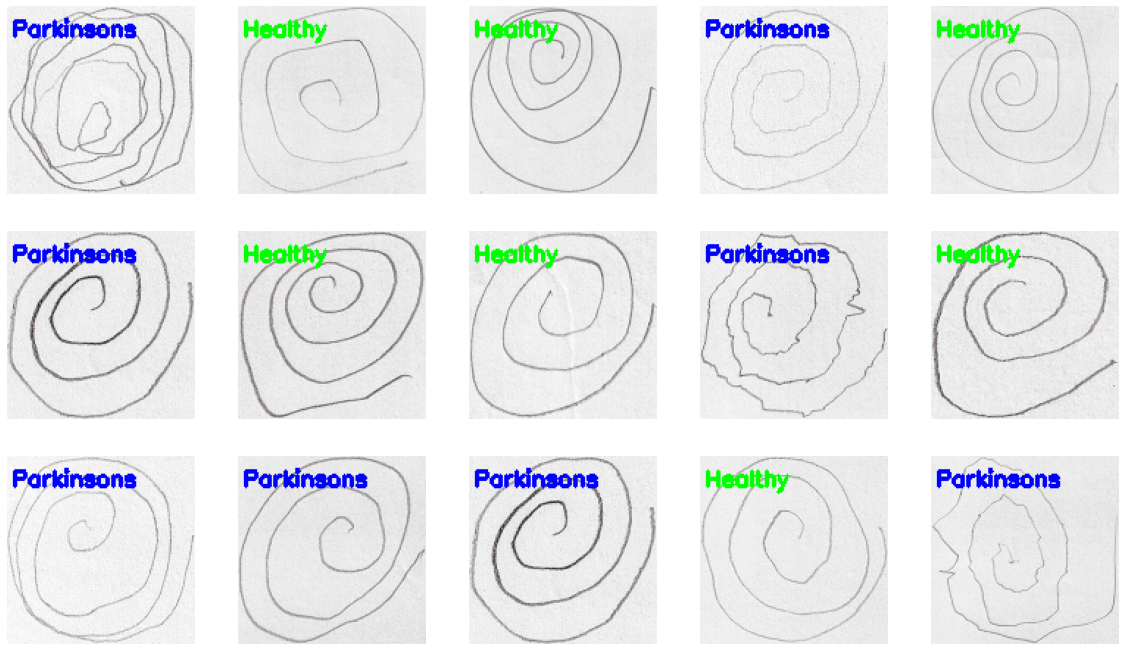

In [9]:
testingPath = os.path.sep.join(["dataset/spiral", "testing"])
test_prediction(spiralmodels['Rf']['classifier'], testingPath)

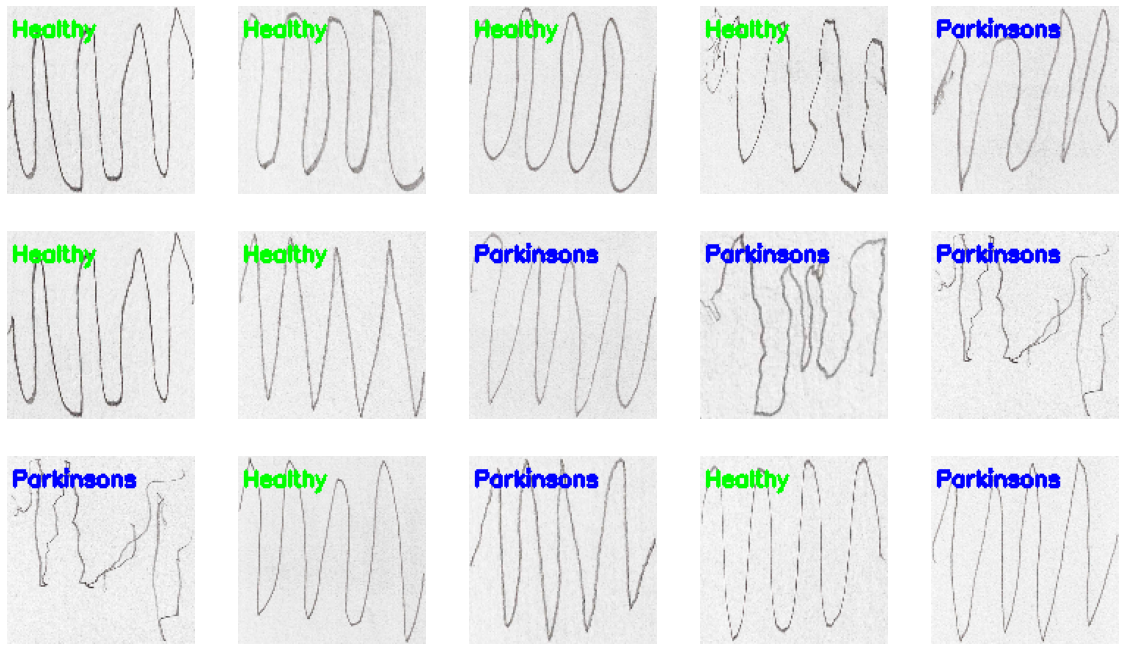

In [10]:
testingPath = os.path.sep.join(["dataset/wave", "testing"])
test_prediction(wavemodels['Rf']['classifier'], testingPath)

In [11]:
def sprediction(model, testingPath):
  image = cv2.imread(testingPath)


  # pre-process the image
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = cv2.resize(image, (200, 200))
  image = cv2.threshold(image, 0, 255,
                        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

  features = feature.hog(image, orientations=9,
                           pixels_per_cell=(10, 10), cells_per_block=(2, 2),
                           transform_sqrt=True, block_norm="L1")
  preds = model.predict([features])
  label = "Parkinsons" if preds else "Healthy"
  return label

In [12]:
testingPath = os.path.sep.join(["dataset/spiral", "testing/parkinson/V01PE01.png"])
label=sprediction(spiralmodels['Rf']['classifier'], testingPath)
print(label)

Healthy


In [14]:
#import joblib
#joblib.dump(spiralmodels,"spiralparkinson1.pkl")
#joblib.dump(wavemodels,"waveparkinson1.pkl")
import pickle
pickle.dump(wavemodels,open("waveparkinson.pkl","wb"))
pickle.dump(spiralmodels,open("spiralparkinson.pkl","wb"))
